# Plot Multiple scans using Gui widgets

To use this notebook:
 1. press shift+enter in the first three cells
 2. Below Cell 3 Make sure your root directory, inturment and experiment number are correct
 3. Press Find scans
 4. select the scans you want to plot together
 5. Press Load
 6. Choose the plot type
 7. select the x and y axis. 
    - The default x is obtained from the first scan. 
    - There is no default y so be sure to select it
    - the color for pcolor or the height in the waterfall is always the detector column.

Each time you press plot, another figure will appear

Details on accessing the figure for saving are given below the figure panel

In [1]:
import collections
import ipywidgets as ipyw
import os
import numpy as np
import neutronpy as npy
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as pyplot

In [2]:
class axis_parms (object):
    def __init__(self,data,axis_label,default_value=None,max_offset=0.0):
        self.data=data
        self.max_offset=max_offset
        jkys=list(data.scans.keys())
        #print (jkys)
        data_columns=data.scans[jkys[0]].data_columns
        # find the maximum length of a column name and determine the width of the selection box
        ta=list(map(lambda x: len(x),data_columns))
        max_wstr=str(np.array(ta).max()*7)+'px'
        # if no column is given as the default value, set the max and min values to 0
        # otherwise set it to the maximum and minimum value of the default column.
        if default_value==None:
            self.axis=ipyw.Select(options=data_columns,layout=ipyw.Layout(width=max_wstr))
            min_val=0.
            max_val=0.
        else:
            self.axis=ipyw.Select(options=data_columns,value=default_value,layout=ipyw.Layout(width=max_wstr))
            min_val=np.min(self.data.min_col(default_value))
            max_val=np.max(self.data.max_col(default_value))+self.max_offset    
        self.min=ipyw.FloatText(value=min_val,layout=ipyw.Layout(width='49px'))
        self.max=ipyw.FloatText(value=max_val,layout=ipyw.Layout(width='49px'))
        #on a change of the axis labels change the maxium and minimum value to correspond to that column.
        self.axis.observe(self.max_min_handler,names="value")
       #set up the max and min part of the gui
        self.min_row=ipyw.HBox([ipyw.Label('Min:'),self.min])
        self.max_row=ipyw.HBox([ipyw.Label('Max:'),self.max])
        self.lim_col=ipyw.VBox([self.min_row,self.max_row])
        self.axis_row=ipyw.HBox([ipyw.Label(axis_label),self.axis,self.lim_col])
    
    def max_min_handler(self,change):
        #upon the change of the column sed new max and min values
        if change['type'] == 'change' and change['name'] == 'value':
          self.min.value=np.min(self.data.min_col(self.axis.value))
          self.max.value=np.max(self.data.max_col(self.axis.value))+self.max_offset

class Dir_builder(object):
    
    def __init__(self,instr_lst=['HB1','HB1A','HB3','CG4C'],root_dir=r"/HFIR/",exp_num=718):
       """
       """
       self.instr_mgn='0px 20px 10px 10px'
       self.dir_path=ipyw.Text(value=root_dir)
       self.instr_name=ipyw.Dropdown(options=instr_lst,value='HB1A',layout=ipyw.Layout(max_width='70px',margin=self.instr_mgn))
       self.exp_name=ipyw.Text(value=str(exp_num),layout=ipyw.Layout(width='50px'),margin='0px 10px 10px 10px')
       self.find_button=ipyw.Button(description='Find scans')
       self.row1=ipyw.HBox([ipyw.Label('Root Directory'),self.dir_path])
       self.row2=ipyw.HBox([ipyw.Label('Instrument'),self.instr_name, ipyw.Label('Experiment #'),self.exp_name])
       self.row3=self.find_button
       self.scans_info=ipyw.VBox([self.row1,self.row2,self.row3])
       display(self.scans_info) 
       self.find_button.on_click(self.display_scans)
       self.sel_fls=None
       self.scans_obj=None
       self.plot_column=None
    
    def assemble_directory(self):
        """
        """
        #print("hello")
        #print (self.instr_name.value,self.exp_name.value)
        self.data_path=self.dir_path.value+self.instr_name.value+os.sep+'exp'+self.exp_name.value+os.sep+'Datafiles'+os.sep
    def display_scans(self,b):
        """
        """
        self.assemble_directory()
        #print (self.data_path)
        out_list=scans_list(self.data_path)
        #height_str=str(np.int(np.ceil(len(out_list)*16.5)))+'px'
        if self.sel_fls==None:
            self.Load_button=ipyw.Button(description="Load")
            self.sel_fls=ipyw.widgets.SelectMultiple(name='scans',options=out_list,layout=ipyw.Layout(display="flex",flex_flow="column"))
            self.col=ipyw.VBox([self.sel_fls,self.Load_button])
            display(self.col)
            self.Load_button.on_click(self.load_scans)
        else:
            self.sel_fls.height=height_str
            self.sel_fls.options=out_list
    
    def load_scans(self,b):
        scan_dict=collections.OrderedDict()
        for fl in self.sel_fls.value:
            scan_dict[fl]=npy.fileio.load_data(str(self.data_path+fl))
        self.scans_obj=npy.data.Scans(scan_dict)
        # determine the column names from the first column.  Need something more general/
        self.sing_scan=self.scans_obj.scans[self.sel_fls.value[0]]
      
        self.plot_type=ipyw.RadioButtons(options=['pcolor','waterfall'],value='pcolor')
        self.plot_type.observe(self.plot_options,names='value') 
        display(self.plot_type)
        self.plot_button=ipyw.Button(description="Plot")
        self.pcolor_controls()
        self.plot_button.on_click(self.make_plot)
                                      
        
    
    def make_plot(self,b):
        if self.plot_type.value=='pcolor':
            self.fig_h=self.scans_obj.pcolor(self.xaxis.axis.value,self.yaxis.axis.value,show_plot=False)
            self.set_x_ylims()
            pyplot.clim(self.zaxis.min.value,self.zaxis.max.value)
            pyplot.show()
        if self.plot_type.value=='waterfall':    
            self.fig_h=self.scans_obj.waterfall(self.xaxis.axis.value,label_column=self.yaxis.axis.value,offset=self.wfall_spacing.value)
            self.set_x_ylims()
            
    def plot_options(self,b):
        if self.plot_column!=None:
            self.plot_column.close()
        # configure plot column for pcolor plot
        if self.plot_type.value=='pcolor':
            self.pcolor_controls()
        elif self.plot_type.value=='waterfall':
        # configure plot column for waterfall plot 
             self.wfall_controls() 
            
    def pcolor_controls(self):
            self.xaxis=axis_parms(self.scans_obj,'x axis',self.sing_scan.plot_default_x)
            self.yaxis=axis_parms(self.scans_obj,'variable')
            self.zaxis=axis_parms(self.scans_obj,'Intensity',self.sing_scan.plot_default_y)                      
            self.axes_row=ipyw.HBox([self.xaxis.axis_row,self.yaxis.axis_row,self.zaxis.axis_row])
            self.plot_column=ipyw.VBox([self.axes_row,self.plot_button])
            display(self.plot_column)
            
    def wfall_controls(self): 
             self.wfall_spacing=ipyw.FloatText(value=5000.0,layout=ipyw.Layout(width='63px'))
             offset=self.wfall_spacing.value*len(self.scans_obj.scans)
             self.xaxis=axis_parms(self.scans_obj,'x axis',self.sing_scan.plot_default_x)   
             self.yaxis=axis_parms(self.scans_obj,'Intensity',self.sing_scan.plot_default_y,max_offset=offset)
             self.Wspacing_row=ipyw.HBox([ipyw.Label('Waterfall spacing: '), self.wfall_spacing])           
             self.axes_row=ipyw.HBox([self.xaxis.axis_row,self.yaxis.axis_row])
             self.plot_column=ipyw.VBox([self.Wspacing_row,self.axes_row,self.plot_button]) 
             display(self.plot_column)
    
    def set_x_ylims(self):
        self.fig_h.axes[0].set_xlim((self.xaxis.min.value,self.xaxis.max.value))
        self.fig_h.axes[0].set_ylim((self.yaxis.min.value,self.yaxis.max.value))
    
#some helper functions                
def scans_list(data_path):
    """
    return a list of files in the given directory with only the .dat extension
    """
    fl_list=os.listdir(data_path)
    dat_list=sorted(list(filter(lambda x:x.find('.dat')>0, fl_list)))
    return dat_list

def box_width(in_lst):
    """
    given a list of strings,  return the length of the longest in pixels
    """
    ta=list(map(lambda x: len(x),in_lst))
    wstr=str(np.array(ta).max()*9)+'px'
    return wstr

    

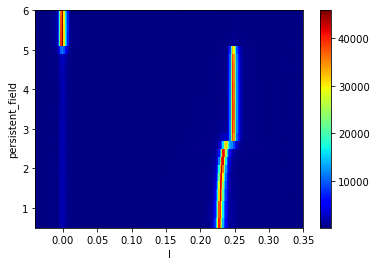

In [3]:
scans_finder=Dir_builder()


The following command changes to the root directory for saving pictures

In [4]:
cd ~

/SNS/users/19g


To further manipulate the figure, you need to grab the figure handle. The handle is the fig_h attribute of the scans_finder object. or scans_finder.fig_h.  The following command is an example that saves the figure.

In [5]:
scans_finder.fig_h.savefig('test2.pdf')
    
    


The following commands show how to set a title and then re display the figure.  Note you can use latex syntax to get specical caharacters.

In [6]:
scans_finder.fig_h.axes[0].set_title('$H_{scan}$')


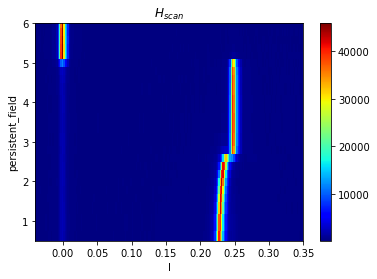

In [7]:
scans_finder.fig_h